In [1]:
# 変数リセット
%reset -s -f

In [2]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

# for CI testing
smoke_test = ('CI' in os.environ)
# assert pyro.__version__.startswith('1.3.1')
pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)


# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
def plot(plot_observed_data=False, plot_predictions=False, n_prior_samples=0,
         model=None, kernel=None, n_test=500):

    plt.figure(figsize=(12, 6))
    if plot_observed_data:
        plt.plot(x.numpy(), y.numpy(), 'kx')
    if plot_predictions:
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        plt.plot(Xtest.numpy(), mean.numpy(), 'r', lw=2)  # plot the mean
        plt.fill_between(Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
                         (mean - 2.0 * sd).numpy(),
                         (mean + 2.0 * sd).numpy(),
                         color='C0', alpha=0.3)
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        noise = (model.noise if type(model) != gp.models.VariationalSparseGP
                 else model.likelihood.variance)
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(torch.zeros(n_test), covariance_matrix=cov)\
                      .sample(sample_shape=(n_prior_samples,))
        plt.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    plt.xlim(-0.5, 5.5)

In [4]:
# 地形の不整地とGDPの相関
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
# "rgdppc_2000"カラムでNaNとinfを取り除く
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
df

,cont_africa,rugged,rgdppc_2000
2,1,0.858,7.492609
4,0,3.427,8.216929
7,0,0.769,9.933263
8,0,0.775,9.407032
9,0,2.688,7.792343
...,...,...,...
229,0,1.677,8.488849
230,0,2.323,6.669180
231,1,1.761,9.150497
232,1,0.533,6.651585


In [5]:
from torch import nn
from pyro.nn import PyroModule

In [6]:
# "cont_africa"と"rugged"をかけた値を新しいカラム"cont_africa_x_rugged"にセット
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]

In [7]:
data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values,
                        dtype=torch.float)
data.shape

torch.Size([170, 4])

In [8]:
# x, y = data[:, :-1], data[:, -1]
x, y = data[:, 1], data[:, -1]
x.shape

torch.Size([170])

In [9]:
kernel = gp.kernels.RBF(input_dim=1, variance=torch.tensor(5.),
                        lengthscale=torch.tensor(10.))
gpr = gp.models.GPRegression(x, y, kernel, noise=torch.tensor(1.))

In [10]:
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2500 if not smoke_test else 2
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

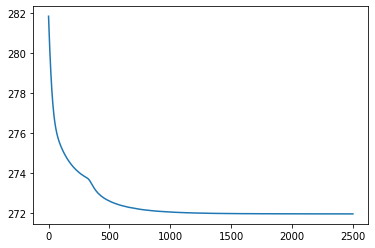

In [11]:
plt.plot(losses);

In [12]:
f_loc, f_cov = gpr(x)
f_loc.shape
std =np.sqrt(f_cov.detach().cpu().numpy()) 
std

array([0.08954604, 0.09018278, 0.08958863, 0.08967375, 0.08975879,
       0.09001343, 0.08984375, 0.09022507, 0.08958863, 0.08954604,
       0.08980128, 0.08984375, 0.08980128, 0.08984375, 0.08950343,
       0.08984375, 0.08992863, 0.08958863, 0.0898862 , 0.08967375,
       0.08954604, 0.08980128, 0.08954604, 0.08984375, 0.08984375,
       0.08967375, 0.09160968, 0.0896312 , 0.08954604, 0.08984375,
       0.08975879, 0.08971629, 0.08984375, 0.08954604, 0.09005579,
       0.08954604, 0.08950343, 0.08975879, 0.08954604, 0.08967375,
       0.08958863, 0.08992863, 0.08984375, 0.08950343, 0.08975879,
       0.08958863, 0.08971629, 0.0896312 , 0.08958863, 0.0898862 ,
       0.08958863, 0.08971629, 0.08954604, 0.08954604, 0.08984375,
       0.08971629, 0.09043623, 0.08984375, 0.0896312 , 0.08967375,
       0.08971629, 0.08971629, 0.08992863, 0.08958863, 0.08958863,
       0.08967375, 0.08967375, 0.08950343, 0.08958863, 0.08958863,
       0.08967375, 0.08954604, 0.08958863, 0.08975879, 0.08963

In [13]:
f_loc

tensor([8.5162, 8.5163, 8.5161, 8.5162, 8.5164, 8.5160, 8.5162, 8.5162, 8.5161,
        8.5164, 8.5161, 8.5162, 8.5160, 8.5161, 8.5161, 8.5161, 8.5161, 8.5166,
        8.5161, 8.5160, 8.5162, 8.5160, 8.5164, 8.5161, 8.5161, 8.5162, 8.5161,
        8.5166, 8.5162, 8.5161, 8.5162, 8.5162, 8.5162, 8.5162, 8.5163, 8.5166,
        8.5163, 8.5165, 8.5162, 8.5160, 8.5163, 8.5159, 8.5161, 8.5162, 8.5162,
        8.5162, 8.5161, 8.5166, 8.5162, 8.5162, 8.5163, 8.5161, 8.5160, 8.5163,
        8.5162, 8.5162, 8.5162, 8.5161, 8.5160, 8.5162, 8.5163, 8.5162, 8.5164,
        8.5164, 8.5163, 8.5162, 8.5165, 8.5163, 8.5162, 8.5167, 8.5162, 8.5164,
        8.5163, 8.5162, 8.5167, 8.5161, 8.5162, 8.5167, 8.5164, 8.5163, 8.5163,
        8.5160, 8.5161, 8.5161, 8.5161, 8.5160, 8.5164, 8.5162, 8.5165, 8.5162,
        8.5163, 8.5160, 8.5164, 8.5161, 8.5162, 8.5162, 8.5160, 8.5164, 8.5162,
        8.5163, 8.5164, 8.5165, 8.5162, 8.5160, 8.5164, 8.5161, 8.5162, 8.5163,
        8.5164, 8.5163, 8.5161, 8.5163, 

In [14]:
fit = df.copy()
fit["mean"] = f_loc.detach().cpu().numpy()
fit["std"] = std

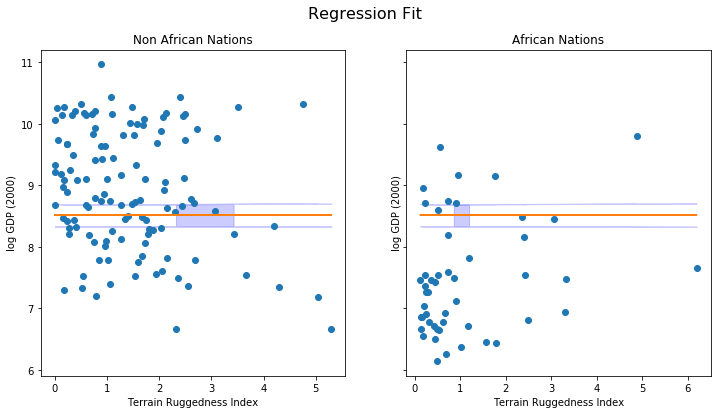

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = fit[fit["cont_africa"] == 1]
non_african_nations = fit[fit["cont_africa"] == 0]
fig.suptitle("Regression Fit", fontsize=16)
# "rgdppc_2000"は上で対数をとって値を入れ直してることに注意。だから縦軸はlog GDP
ax[0].plot(non_african_nations["rugged"], non_african_nations["rgdppc_2000"], "o")
ax[0].plot(non_african_nations["rugged"], non_african_nations["mean"])
ax[0].fill_between(non_african_nations["rugged"], non_african_nations["mean"] + 2*non_african_nations["std"], non_african_nations["mean"] - 2*non_african_nations["std"], alpha=.2, color='blue')
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
ax[1].plot(african_nations["rugged"], african_nations["rgdppc_2000"], "o")
ax[1].plot(african_nations["rugged"], african_nations["mean"])
ax[1].fill_between(african_nations["rugged"], african_nations["mean"] + 2*african_nations["std"], african_nations["mean"] - 2*african_nations["std"], alpha=.2, color='blue')
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");
